In [1]:
import psycopg2
import json
import numpy as np
import pandas as pd
import datetime
import os
from nltk.corpus import words
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
plt.style.use("ggplot")
%matplotlib inline

/Users/brian/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def  plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

In [48]:
with open("../../elections_login.json", "rb") as f:
    login_info = json.load(f)

In [49]:
conn = psycopg2.connect(host=login_info["ip"]
                       ,dbname=login_info["db"]
                       ,user=login_info["username"]
                       ,password=login_info["password"])

In [50]:
cursor = conn.cursor()

In [51]:
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tables = [x[0] for x in cursor.fetchall()]

In [52]:
tables

['ballots',
 'committee_history',
 'transaction_details',
 'committees_list',
 'donor',
 'election_activity',
 'payee',
 'statement_of_org',
 'transactions']

In [53]:
transactions_df = pd.read_sql("SELECT * FROM transactions", conn)

In [55]:
conn.close()

## First lets see the relationship between ammount and ballot counts.

In [ ]:
d1 = {'name': 'Jane Smith', 
      'campaigns': [{'year': 2016, 
                     'pos': 'myr', 
                     'votes': {'county_a': 300,
                               'county_b': 480}}, 
                    {'year': 2017, 
                     'pos': 'gov', 
                     'votes': {'county_a': 750,
                               'county_b': 800,
                               'county_c': 650}}
                   ]
     }
d2 = {'name': 'John Doe', 
      'campaigns': [{'year': 2016, 
                     'pos': 'myr', 
                     'votes': {'county_a': 150,
                               'county_b': 370}}, 
                    {'year': 2017, 
                     'pos': 'sen', 
                     'votes': {'county_a': 460,
                               'county_b': 500,
                               'county_d': 350}}
                   ]
     }

In [ ]:
def _match_names(candidate):
    name_parts = [x for i,x in enumerate(candidate.split(" ")) if i == 0 or i == len(candidate.split(" ")) - 1]
    name_parts.append(str.join(" ", name_parts))
    committee_names = money_in_df.filer_committee.unique()
    possibilities = []
    for committee in committee_names:
        for ind, name_part in enumerate(name_parts):
            if name_part in committee:
                com_split = committee.split(" ")
                if ind == 0:
                    print(com_split)
                    loc = np.argwhere(np.array(com_split) == name_part)[0][0]
                    if com_split[loc + 1] in words.words():
                        possibilities.append(committee)
                elif ind == 1:
                    loc = np.argwhere(np.array(com_split) == name_part)[0][0]
                    if com_split[loc - 1] in words.words():
                        possibilities.append(committee)
                elif ind == 2:
                    possibilities.append(committee)
    return possibilities

# NEW METHOD

**FINDING ELECTION SEASONS**

In [68]:
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
money_in_df = transactions_df[transactions_df.transaction_subtype == "Cash Contribution"].copy()
money_out_df = transactions_df[transactions_df.transaction_subtype == "Cash Expenditure"].copy()

In [69]:
def next_weekday(d):
    weekday = d.weekday()
    if weekday < 3:
        d = d - datetime.timedelta(weekday)
    else:
        d = d + datetime.timedelta(7 - weekday)
    return d

In [70]:
def next_month(d):
    day = d.day
    month = d.month
    year = d.year
    if day < 15:
        day = 1
    if day >= 15:
        if month == 12:
            month = 1
            day = 1
            year = year + 1
        else:
            month = month + 1
            day = 1
    return datetime.date(year, month, day)

In [71]:
money_in_df["week_round"] = money_in_df.transaction_date.map(lambda x:next_weekday(x))
money_in_df["month_round"] = money_in_df.transaction_date.map(lambda x: next_month(x))
money_in_df["week_round"] = pd.to_datetime(money_in_df.week_round)
money_in_df["month_round"] = pd.to_datetime(money_in_df.month_round)

In [72]:
month_round_df = money_in_df[["month_round", "amount"]].groupby("month_round").agg("count")
week_round_df = money_in_df[["week_round", "amount"]].groupby("week_round").agg("count")

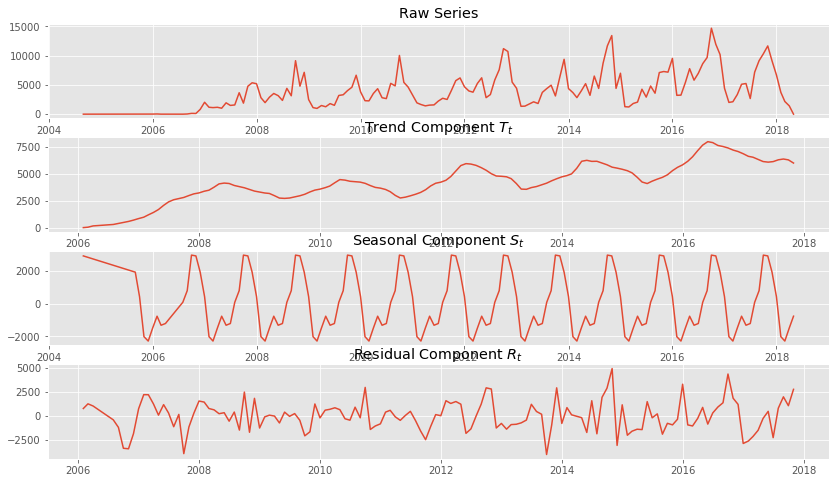

In [73]:
month_decomp = sm.tsa.seasonal_decompose(month_round_df, freq=12)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs,month_round_df,month_decomp)

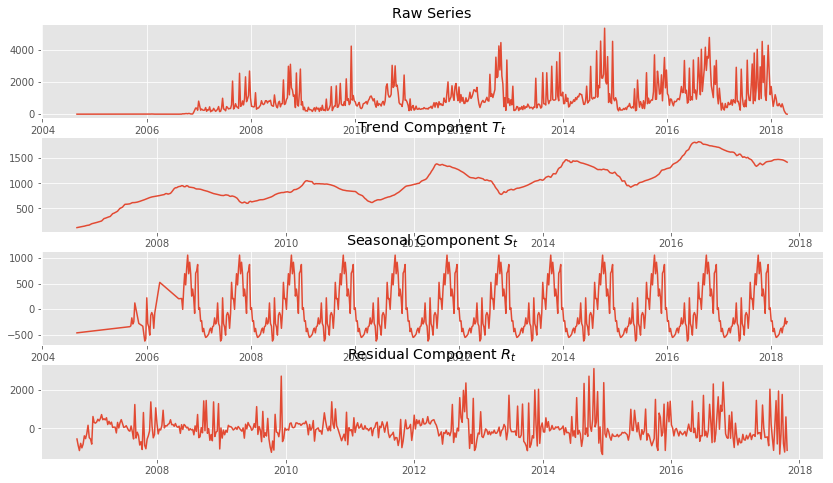

In [74]:
week_decomp = sm.tsa.seasonal_decompose(week_round_df, freq=52)
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs,week_round_df,week_decomp)

For each campaign season:
* Which comittee / pac fm the candidate name the best?
* How much money did they take in?
* How much money did the second most take in?

In [75]:
money_in_df.columns

Index(['transaction_id', 'committee_id', 'transaction_date', 'status',
       'filer_committee', 'contributor_payee', 'transaction_subtype', 'amount',
       'week_round', 'month_round'],
      dtype='object')

In [76]:
def get_comittee_matches(candidate, top_n):
    years_dict = {}
    for year in range(2004, 2018):
        range_df = money_in_df[money_in_df.transaction_date >= "{0}-03-01".format(year)]
        range_df = range_df[range_df.transaction_date < "{0}-03-01".format(year+1)]
        choices = range_df.filer_committee.unique()
        top = process.extract(candidate, choices, limit = top_n)
        years_dict[year] = top
    return years_dict

In [77]:
def get_contributions(candidate, year, top_n=3):
    year_dict = get_comittee_matches(candidate,top_n)
    comittee_matches = year_dict[year]
    comitteee_amounts = {}
    for committee in comittee_matches:
        amount = money_in_df[money_in_df.filer_committee == committee[0]]["amount"].sum()
        comitteee_amounts[committee[0]] = {"match": committee[1],
                                           "amount": amount}
    return comitteee_amounts

In [78]:
get_contributions("Tony DeBone", 2013, 10)

{'Citizens for Tony DeBone': {'amount': 102521.76000000001, 'match': 90},
 'Coastal Conservation Oregon PAC': {'amount': 60972.51, 'match': 58},
 'Curry County Democratic Central Committee': {'amount': 27878.88,
  'match': 58},
 'Deschutes County Democratic Central Committee': {'amount': 85534.92,
  'match': 58},
 'Douglas County Democratic Central Committee': {'amount': 93919.34,
  'match': 58},
 'Hood River County Democratic Central Committee': {'amount': 9941.6,
  'match': 58},
 'Klamath County Democratic Central Committee': {'amount': 19314.41,
  'match': 58},
 'Multnomah County Democratic Central Committee': {'amount': 575673.71,
  'match': 58},
 'Tillamook County Democratic Central Committee': {'amount': 12974.880000000001,
  'match': 58},
 'Wasco County Democratic Central Committee': {'amount': 30441.89,
  'match': 58}}